## Visualizing Spatial Data with Pandas and Folium

In [1]:
import os
DATADIR = os.path.join(os.path.expanduser("~"),"DATA",
                       "Misc")
print(os.path.exists(DATADIR))
import pandas as pd
import numpy as np

True


In [3]:
!whoami

dgroat


In [4]:
#!pip install folium
import folium


`Accidents7904.csv` located in `~/DATA/Misc` is a a record of all the automobile accidents in the UK between 1974 and 2004. This is quite a large data set but nothing that Pandas can't handle, in principle. However, given that we don't want to over tax our system, we will limit ourselves to reading in only parts of the data.

The original data contains 6224198 rows. However, because GPS was not declassified until the late 1990s, the early accidents do not have lattitude and longitude values are so not of interest to us. The first longitude/lattitude value occurs at row 4883216.

We can use the [`skiprows`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) keyword. 

`skiprows` can take
* An integer number of rows to skip
* A sequence (e.g. a list) of row numbers to skip
* Or a function that returns `True` if the row should be skipped and `False` otherwise.

### Read in the data

We'll use a `lambda` function to specify which rows to skip

In [5]:
data = pd.read_csv(os.path.join(DATADIR, "Accidents7904.csv"),
                        skiprows = lambda index: index >0 and index <=4883216 
                   
                        )#.dropna()

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### What are our columns?

In [6]:
data.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

### What are the values in these columns?

In [7]:
data['Accident_Severity'].unique()

array([3, 2, 1])

In [8]:
data["Number_of_Casualties"].unique()

array([ 1,  2,  3,  5,  4,  7,  9,  6,  8, 13, 14, 21, 10, 28, 11, 24, 15,
       17, 23, 12, 16, 20, 32, 18, 30, 22, 27, 19, 33, 34, 41, 31, 36, 46,
       90, 37, 35, 79, 25, 40, 26, 29, 45, 39, 38, 42, 71, 48, 47, 51, 55,
       67])

In [9]:
data["Light_Conditions"].unique()

array([ 1,  6,  4,  5,  7, -1])

## Let's limit ourselves to the following columns:

* `Longitude`
* `Lattitude`
* `Time`
* `Number_of_Casualites`

In [11]:
data = pd.read_csv(os.path.join(DATADIR, "Accidents7904.csv"),
                   usecols=['Longitude',"Latitude",
                            "Date", "Time","Number_of_Casualties"],
                   skiprows = lambda index: index >0 and index <=4883216 )
                   
                        

In [12]:
data.head()

,Longitude,Latitude,Number_of_Casualties,Date,Time
0,-0.271752,51.715661,1,25/12/1999,09:30
1,-0.239977,51.695136,1,17/12/1999,18:38
2,-0.270037,51.715096,2,15/12/1999,18:04
3,-0.263233,51.711309,1,02/12/1999,04:10
4,-0.227225,51.688200,3,04/12/1999,09:51


In [13]:
data.shape

(1340982, 5)

### We can drop missing values

In [14]:
data2 = data.dropna()

In [15]:
data2.shape

(1336875, 5)

In [19]:
type(data2.iloc[0,3])

pandas._libs.tslibs.timestamps.Timestamp

In [27]:
type(data2.loc[0,"Time"])

datetime.time

#### Date's and Times are not recognized as such and so are left as strings

* We could set `locale`
* Or we can convert later

In [18]:
data2["Date"] = pd.to_datetime(data2["Date"],format="%d/%m/%Y", 
                              errors='ignore')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
from datetime import datetime
tmp = datetime.strptime("09:30","%H:%M")
print(tmp)
print(tmp.time())

1900-01-01 09:30:00
09:30:00


In [26]:
data2["Time"] = data2.apply(lambda row: datetime.strptime(row["Time"],"%H:%M").time(), 
                            axis=1)

TypeError: ('strptime() argument 1 must be str, not datetime.time', 'occurred at index 0')

In [ ]:
%debug

In [28]:
data2.head()

,Longitude,Latitude,Number_of_Casualties,Date,Time
0,-0.271752,51.715661,1,1999-12-25,09:30:00
1,-0.239977,51.695136,1,1999-12-17,18:38:00
2,-0.270037,51.715096,2,1999-12-15,18:04:00
3,-0.263233,51.711309,1,1999-12-02,04:10:00
4,-0.227225,51.688200,3,1999-12-04,09:51:00


####  We can use the [``sample``](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html) method to get a subset of DataFrame

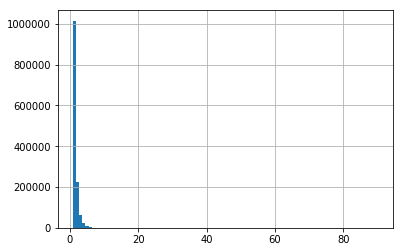

In [36]:
data2["Number_of_Casualties"].hist(bins=100)

In [29]:
subdata = data2.sample(200)
mean_long = np.mean(subdata['Longitude'])
mean_lat  = np.mean(subdata['Latitude'])


In [30]:
map = folium.Map(location=[mean_lat, mean_long], 
                 tiles="Stamen Terrain", zoom_start=5.5)
for _, s in subdata.iterrows():
    rslt = folium.Marker([s["Latitude"], s["Longitude"]],
                  popup="%s\n%s\n# Causalities: %d"%(s["Date"],
                                                     s["Time"],
                                                     s["Number_of_Casualties"]),
                  icon=folium.Icon(icon='cloud')).add_to(map)

In [31]:
map

### Example 2

* Filter Pandas DataFrame on number of casualties
* Select different [Bootstrap icon](https://www.w3schools.com/icons/bootstrap_icons_glyphicons.asp)
* Set different color

In [33]:
map2 = folium.Map(location=[mean_lat, mean_long], 
                 tiles="Stamen Terrain", zoom_start=5.5)
for _, s in data2[data2["Number_of_Casualties"]>20].iterrows():
    rslt = folium.Marker([s["Latitude"], s["Longitude"]],
                  popup="%s\n%s\n# Causalities: %d"%(s["Date"],
                                                     s["Time"],
                                                     s["Number_of_Casualties"]),
                  icon=folium.Icon(icon='info-sign', color='red')).add_to(map2)

In [34]:
map2